### settup

In [ ]:
!pip install yfinance pandas matplotlib plotlypip gym
!pip install arch pmdarima stable_baselines3
!pip install gymnasium
!pip install 'shimmy>=2.0'
!pip install --upgrade scikit-learn arch pmdarima
!pip list | grep -E "scikit-learn|arch|pmdarima"
import numpy as np
import warnings
warnings.filterwarnings("error", category=FutureWarning)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# !pip install arch

### Dataset

In [2]:
import yfinance as yf

class Dataset:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None

    def fetch_data(self):
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date).dropna()
        return self.data

    def calculate_metrics(self, days):
      self.data = self.data.dropna()
      self.data['Returns'] = self.data['Close'].pct_change() * 100
      self.data['Realized_Volatility'] = self.data['Returns'].rolling(window=30).std()

      return self.data

    def split_data(self, split_date):
      self.data = self.data.sort_index()

      training_data = self.data.loc[:split_date]
      testing_data = self.data.loc[split_date:]

      training_instance = Dataset(self.ticker, self.start_date, split_date)
      testing_instance = Dataset(self.ticker, split_date, self.end_date)
      training_instance.data = training_data
      testing_instance.data = testing_data

      return training_instance, testing_instance

    def add_cripto_index(self, other_tickers):
        cripto_datasets = []
        tickers = other_tickers

        for ticker in tickers:
            dataset_btc = Dataset(ticker=ticker, start_date=start_date, end_date=end_date)
            dataset_btc.fetch_data()
            dataset_btc.data = dataset_btc.data.dropna()
            cripto_datasets.append(dataset_btc.data)

        combined_data = pd.concat(cripto_datasets, axis=1)

        index_values = []

        for date, row in combined_data.iterrows():
          total_volume_price = 0
          weights = {}

          for ticker in tickers:
            total_volume_price += row['Volume'][ticker] * row['Close'][ticker]

          index_value = 0
          for ticker in tickers:
              weight = (row['Volume'][ticker] * row['Close'][ticker]) / total_volume_price
              weights[ticker] = weight
              index_value += weight * row['Close'][ticker]

          index_values.append(index_value)


        index_values_series = pd.Series(index_values, index=combined_data.index)
        self.data['My_index'] = index_values_series

        self.data['Index_Returns'] = self.data['My_index'].pct_change() * 100
        self.data['Index_Realized_Volatility'] = self.data['Index_Returns'].rolling(window=30).std()

        return self.data

### DiagramPlotter

In [3]:
import matplotlib.pyplot as plt

class DiagramPlotter:
    def __init__(self, figsize=(10, 5)):
        self.figsize = figsize

    def plot_volatility(self, forecasted_volatility, realized_volatility, title, xlabel, ylabel):
        fig, ax = plt.subplots(figsize=self.figsize)

        ax.plot(range(1, len(forecasted_volatility) + 1), forecasted_volatility,
                label='Forecasted Volatility', linestyle='--', color='blue')
        ax.plot(range(1, len(realized_volatility) + 1), realized_volatility,
                label='Realized Volatility', linestyle='-', color='orange')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel, color='black')
        ax.tick_params(axis='y', labelcolor='black')
        ax.legend(loc='upper left')

        ax.grid(True)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_multiple_data(self, data, title, xlabel, ylabel):
        self.figsize = figsize=(10, 5)
        fig, ax = plt.subplots(figsize=self.figsize)

        for label, (dates, values) in data.items():
            ax.plot(dates, values, label=label)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel, color='black')
        ax.tick_params(axis='y', labelcolor='black')
        ax.legend(loc='upper left')

        ax.grid(True)
        plt.title(title)
        plt.tight_layout()
        plt.show()

### MetricsTester

In [4]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class MetricsTester:
    @staticmethod
    def evaluate_metrics(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)

        return {
            'RMSE': rmse,
            'MAPE': mape,
        }

### Indeksas

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def cripto_index_stats(dataset_btc, cripto_index):
  dataset_btc.data['Realized_Log_Volatility'].plot()
  cripto_index['Realized_Log_Volatility'].dropna().plot()
  plt.show()

  difference = (
      dataset_btc.data['Realized_Log_Volatility']
      - cripto_index['Realized_Log_Volatility']
  ).dropna()

  difference.plot(title="Difference in Realized Log Volatility", xlabel="Date", ylabel="Difference dataset_btc-combined_data")
  plt.show()

### GARCHModel

In [6]:
from arch import arch_model
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

class GARCHModel:
    def __init__(self, main_dataset, p=1, q=1, mean='Zero', vol='Garch', dist='Normal'):
        self.p = p
        self.q = q
        self.mean = mean
        self.vol = vol
        self.dist = dist
        self.model = None
        self.fitted_model = None
        self.main_dataset = main_dataset

    def predict(self, start_date, forecast_days, p, retAll=False):
        if self.main_dataset is None or self.main_dataset.data.empty:
            raise ValueError("Dataset is empty or None. Provide a valid dataset.")
        # start_range = start_date - timedelta(days=30)
        # self.model = arch_model(self.main_dataset.data.loc[start_range:start_date, 'Returns'],
        self.model = arch_model(self.main_dataset.data.loc[:start_date, 'Returns'],
                                mean=self.mean,
                                vol=self.vol,
                                p=self.p,
                                q=self.q,
                                dist=self.dist,
                                rescale=False)
        self.fitted_model = self.model.fit(disp='off')

        forecasts = self.fitted_model.forecast(horizon=forecast_days, start=start_date)
        mean_forecast = forecasts.mean.iloc[-1]
        variance_forecast = forecasts.variance.iloc[-1,:]

        forecast_index = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=forecast_days)

        pred_volatility = pd.Series(
            np.sqrt(forecasts.variance.iloc[-1].values), index=forecast_index
        )

        if p:
          realized_volatility = dataset_btc.data.loc[start_date:start_date + pd.Timedelta(days=forecast_days - 1), 'Realized_Volatility']
          prior_data = dataset_btc.data.loc[start_date - pd.Timedelta(days=forecast_days):start_date - pd.Timedelta(days=1), 'Realized_Volatility']
          realized_with_prior = pd.concat([prior_data, realized_volatility])

          aligned_predictions = pd.Series(pred_volatility, index=forecast_index)

          aligned_predictions = aligned_predictions.reindex(realized_with_prior.index)
          aligned_predictions = aligned_predictions[-len(realized_volatility):]

          data_to_plot = {
              'Prognozuotas kintamumas': (aligned_predictions.index, aligned_predictions),
              'Realizuotas kintamumas': (realized_with_prior.index, realized_with_prior),
          }

          plotter = DiagramPlotter()
          plotter.plot_multiple_data(data=data_to_plot, title=f"GARCH modelio prognozuotas ir realizuotas kintamumas {start_date.date()} dienai", xlabel="Data", ylabel="Kintamumas %")

        if retAll:
          return pred_volatility
        else:
          return pred_volatility.iloc[-1]

    def predict_over_test_range(self, dataset_test, forecast_days, p, metrics):
        predictions = []

        for start_date in dataset_test.data.index[forecast_days:]:

            if start_date + pd.Timedelta(days=forecast_days - 1) >= dataset_test.data.index[-1]:
                break

            forecast = self.predict(
                start_date,
                forecast_days,
                p=False
            )

            new_date = start_date + timedelta(days=forecast_days)

            predictions.append({
                'Date': new_date,
                'Predicted Volatility': forecast
            })

        predictions = pd.DataFrame(predictions)

        realized_volatility = dataset_btc.data.loc[dataset_test.data.index[forecast_days]:dataset_test.data.index[-1], 'Realized_Volatility'][forecast_days:]

        if p:
          data_to_plot = {
              'Prognozuotas kintamumas (apskaičiuotas prieš 30 dienų)': (predictions['Date'], predictions['Predicted Volatility']),
              'Realizuotas kintamumas': (realized_volatility.index, realized_volatility)
          }

          plotter = DiagramPlotter()
          plotter.plot_multiple_data(data=data_to_plot, title="GARCH modelio prognozuotas ir realizuotas kintamumas testavimo periodui", xlabel="Data", ylabel="Kintamumas %")

        if metrics:
          y_true = realized_volatility
          y_pred = predictions['Predicted Volatility']
          tester = MetricsTester()
          scores = tester.evaluate_metrics(y_true, y_pred)
          print("Metrikų įverčiai:", scores)

        return predictions


### LSTMModel

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class LSTMModel:
    def __init__(self, lag, forecast_horizon, model_path='/content/drive/MyDrive/Colab Notebooks/model.keras'):
        self.lag = lag
        self.forecast_horizon = forecast_horizon
        self.model_path = model_path
        self.scaler_X = MinMaxScaler(feature_range=(0, 1))
        self.scaler_y = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    def create_lagged_features(self, series):
        X, y = [], []
        for i in range(len(series) - self.lag - self.forecast_horizon + 1):
            X.append(series[i:i + self.lag])
            y.append(series[i + self.lag:i + self.lag + self.forecast_horizon])
        return np.array(X), np.array(y)

    def preprocess_data(self, data_series):

      X, y = self.create_lagged_features(data_series.values)


      X_flattened = X.reshape(X.shape[0], -1)
      X_scaled = self.scaler_X.fit_transform(X_flattened)
      y_scaled = self.scaler_y.fit_transform(y)

      X = X_scaled.reshape(X.shape[0], self.lag, 1)

      return X, y_scaled

    def build_model(self):
        self.model = Sequential([
            InputLayer((self.lag, 1)),
            LSTM(128, activation='relu', return_sequences=False),
            Dense(64, activation='relu'),
            Dense(self.forecast_horizon, activation='linear')
        ])
        self.model.compile(
            loss=MeanSquaredError(),
            optimizer=Adam(learning_rate=0.001),
            metrics=[RootMeanSquaredError()]
        )
        self.model.summary()

    def train(self, X_train, y_train, validation_split=0.2, epochs=10, batch_size=32):
        cp = ModelCheckpoint(self.model_path, save_best_only=True)
        history = self.model.fit(
            X_train, y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[cp]
        )
        return history

    def load_best_model(self):
        self.model = load_model(self.model_path)

    def evaluate(self, X_train, y_train, X_test, y_test):
        # Train predictions
        train_predictions = self.model.predict(X_train)
        train_predictions_original = self.scaler_y.inverse_transform(train_predictions)
        y_train_original = self.scaler_y.inverse_transform(y_train)

        train_results = pd.DataFrame({
            'Train Predictions': train_predictions_original.flatten(),
            'Actuals': y_train_original.flatten()
        })

        # Plot train results
        plt.plot(train_results['Train Predictions'][:100], label="Train Predictions")
        plt.plot(train_results['Actuals'][:100], label="Actuals")
        plt.legend()
        plt.title("Training Results")
        plt.show()

        # Test predictions
        test_predictions = self.model.predict(X_test)
        test_predictions_original = self.scaler_y.inverse_transform(test_predictions)
        y_test_original = self.scaler_y.inverse_transform(y_test)

        test_results = pd.DataFrame({
            'Test Predictions': test_predictions_original.flatten(),
            'Actuals': y_test_original.flatten()
        })

        # Plot test results
        plt.plot(test_results['Test Predictions'][:100], label="Test Predictions")
        plt.plot(test_results['Actuals'][:100], label="Actuals")
        plt.legend()
        plt.title("Testing Results")
        plt.show()

        return train_results, test_results

    def predict(self, X_test):
        predictions = self.model.predict(X_test, verbose=0)
        return predictions


    def prepare_single_point(self, array_60_days):

      if len(array_60_days) != 60:
          raise ValueError("Input array must contain exactly 60 elements.")

      X_raw = np.array(array_60_days[:30]).reshape(1, -1)
      y_raw = np.array(array_60_days[30:]).reshape(1, -1)

      X_scaled = self.scaler_X.transform(X_raw).reshape(1, 30, 1)
      y_scaled = self.scaler_y.transform(y_raw)

      return X_scaled, y_scaled

    def predict_One(self, test_dataset, center_index, p, retAll=False):
      X_scaled, y_scaled = self.prepare_single_point(test_dataset.data['Realized_Volatility'][center_index - 29:center_index + 30 + 1])
      predicted_30_days =  self.predict(X_scaled)
      train_predictions_original = self.scaler_y.inverse_transform(predicted_30_days)
      y_train_original = self.scaler_y.inverse_transform(y_scaled)

      forecast_index = pd.date_range(
          start=test_dataset.data.index[center_index] + pd.Timedelta(days=1),
          periods=30
      )

      pred = pd.Series(
          train_predictions_original[-1], index=forecast_index
      )

      actual = pd.Series(
          y_train_original[-1], index=forecast_index
      )

      if p:
        data_to_plot = {
            'Prognozuotas kintamumas': (forecast_index, pred),
            'Realizuotas kintamumas': (test_dataset.data.index[center_index - 29:center_index + 30 + 1], test_dataset.data['Realized_Volatility'][center_index - 29:center_index + 30 + 1])
        }

        plotter = DiagramPlotter()
        plotter.plot_multiple_data(data=data_to_plot, title="LSTM modelio prognozuotas ir realizuotas kintamumas 2024-08-18 dienai", xlabel="Data", ylabel="Kintamumas %")

      if retAll:
          return pred
      else:
        return pred.iloc[-1]

    def predict_over_range(self, dataset_test, forecast_days, p=False, metrics=False):
      predictions = []

      start_idx = 30
      end_idx = len(dataset_test.data) - forecast_days

      for idx in range(start_idx, end_idx):
          forecast = self.predict_One(
              dataset_test,
              center_index=idx,
              p=False
          )

          new_date = dataset_test.data.index[idx] + pd.Timedelta(days=forecast_days)

          predictions.append({
              'Date': new_date,
              'Predicted Volatility': forecast
          })

      predictions = pd.DataFrame(predictions)

      realized_volatility = dataset_test.data.loc[
          dataset_test.data.index[start_idx+30:len(dataset_test.data)],
          'Realized_Volatility'
      ]

      if p:
          data_to_plot = {
              'Prognozuotas kintamumas (apskaičiuotas prieš 30 dienų)': (predictions['Date'], predictions['Predicted Volatility']),
              'Realizuotas kintamumas': (realized_volatility.index, realized_volatility.values)
          }

          plotter = DiagramPlotter()
          plotter.plot_multiple_data(
              data=data_to_plot,
              title="LSTM modelio prognozuotas ir realizuotas kintamumas testavimo periodui",
              xlabel="Data",
              ylabel="Kintamumas %"
          )

      if metrics:
          y_true = realized_volatility.values
          y_pred = predictions['Predicted Volatility'].values

          tester = MetricsTester()
          scores = tester.evaluate_metrics(y_true, y_pred)
          print("Metrics Scores:", scores)

      return predictions

### Models run

#### Basic

In [8]:
import pandas as pd

# Settings
days = 30
start_date = '2018-01-01'
end_date ='2025-01-01'
data_split_date_for_models = '2021-12-31'
data_split_date_for_system = '2023-12-31'
other_tickers = ['XRP-USD', 'ETH-USD', 'BNB-USD', 'LTC-USD']
center_index = 231

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


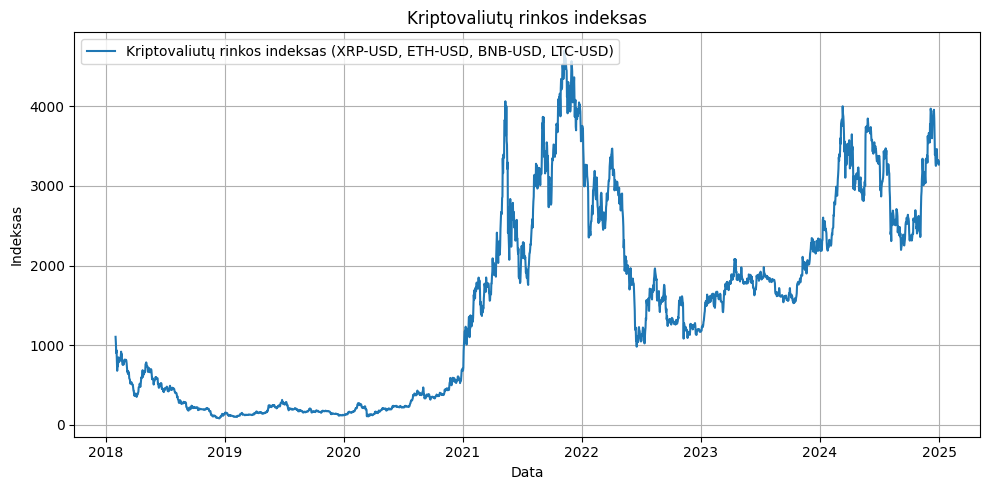

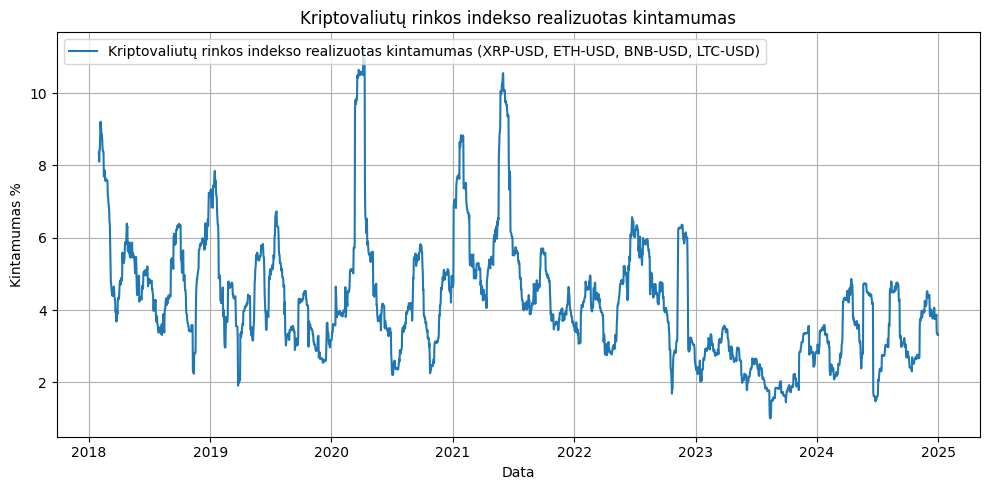

In [9]:
# Duomenų paruošimas
dataset_btc = Dataset(ticker='BTC-USD', start_date=start_date, end_date=end_date)
dataset_btc.fetch_data()
dataset_btc.calculate_metrics(days)

# Indekso apskaičiavimas
dataset_btc.data = dataset_btc.add_cripto_index(other_tickers).dropna()

data_to_plot = {
    f"Kriptovaliutų rinkos indeksas ({', '.join(other_tickers)})": (dataset_btc.data.index, dataset_btc.data['My_index']),
}

plotter = DiagramPlotter()
plotter.plot_multiple_data(data=data_to_plot, title="Kriptovaliutų rinkos indeksas", xlabel="Data", ylabel="Indeksas")

data_to_plot = {
    f"Kriptovaliutų rinkos indekso realizuotas kintamumas ({', '.join(other_tickers)})": (dataset_btc.data.index, dataset_btc.data['Index_Realized_Volatility']),
}

plotter = DiagramPlotter()
plotter.plot_multiple_data(data=data_to_plot, title="Kriptovaliutų rinkos indekso realizuotas kintamumas", xlabel="Data", ylabel="Kintamumas %")

# Gauname 3 duomenu aibes: model_dataset, train_dataset, test_dataset
model_dataset, tmp = dataset_btc.split_data(data_split_date_for_models)
train_dataset, test_dataset = tmp.split_data(data_split_date_for_system)

#### GARCHModel

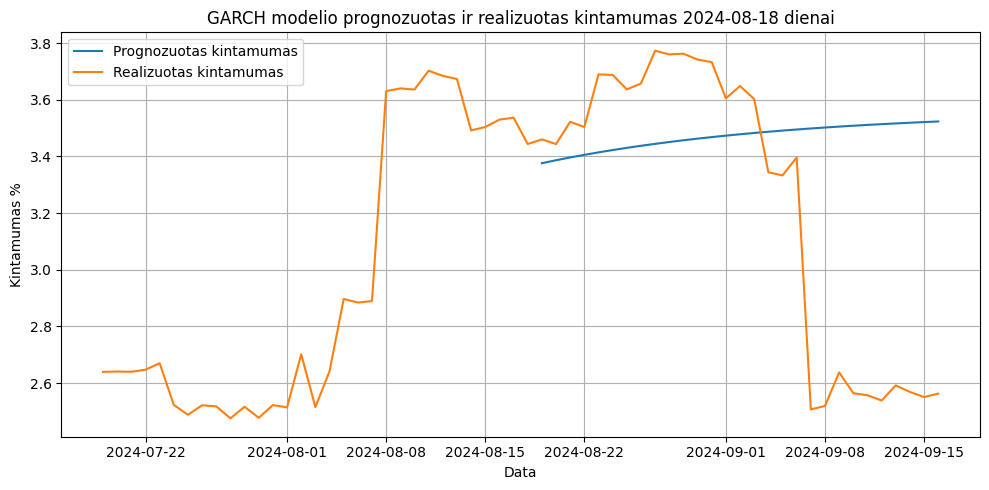

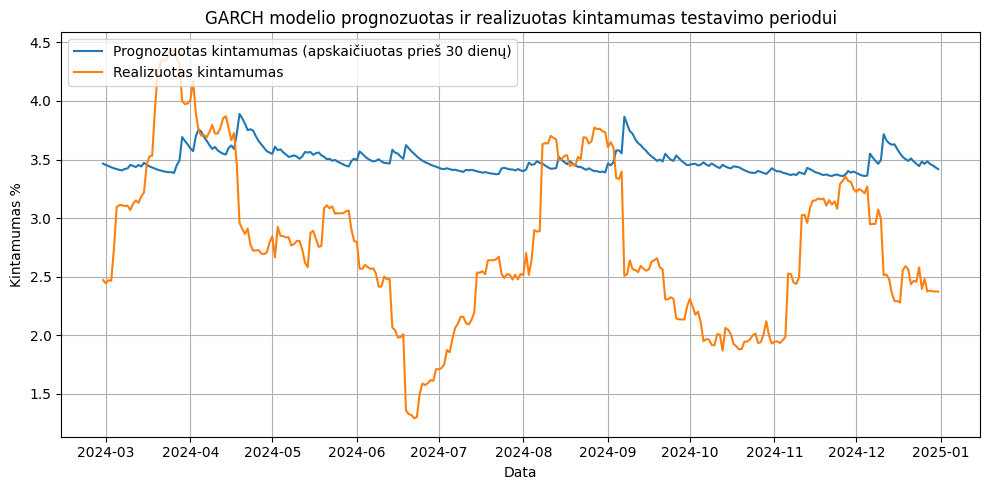

Metrikų įverčiai: {'RMSE': 0.981542234110623, 'MAPE': 36.70723269301766}


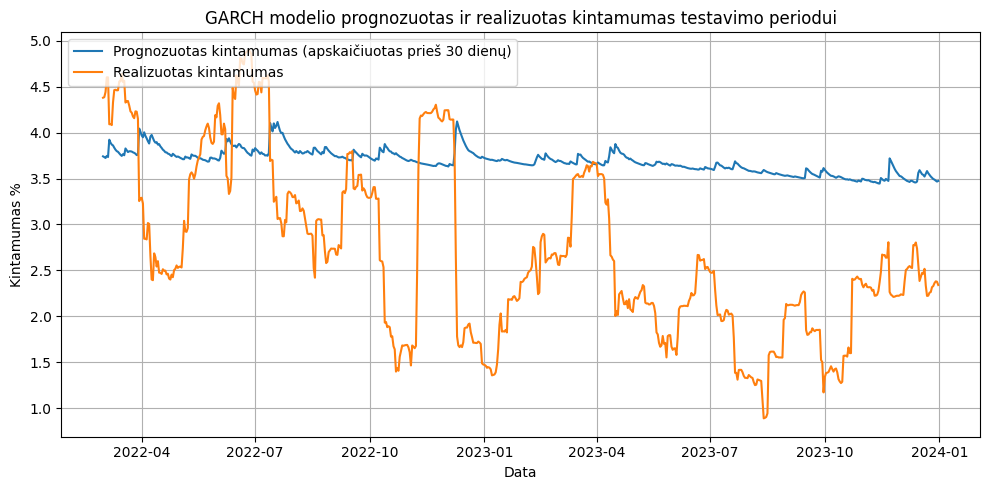

Metrikų įverčiai: {'RMSE': 1.3531539986955774, 'MAPE': 59.572652145146876}


In [10]:
# Init
garch_model = GARCHModel(dataset_btc)
# Train
  # None. Before each forecast there is fitting with available data
# Test one
GARCHprediction = garch_model.predict(test_dataset.data.index[center_index], days, p=True, retAll=True)
# Eval
Eval_GARCH_predictions = garch_model.predict_over_test_range(test_dataset, days, p=True, metrics=True)

# Calculate for training
Train_GARCH_predictions = garch_model.predict_over_test_range(train_dataset, days, p=True, metrics=True)

#### LSTMModel

Mounted at /content/drive


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,766 (299.87 KB)

 Trainable params: 76,766 (299.87 KB)

 Non-trainable params: 0 (0.00 B)

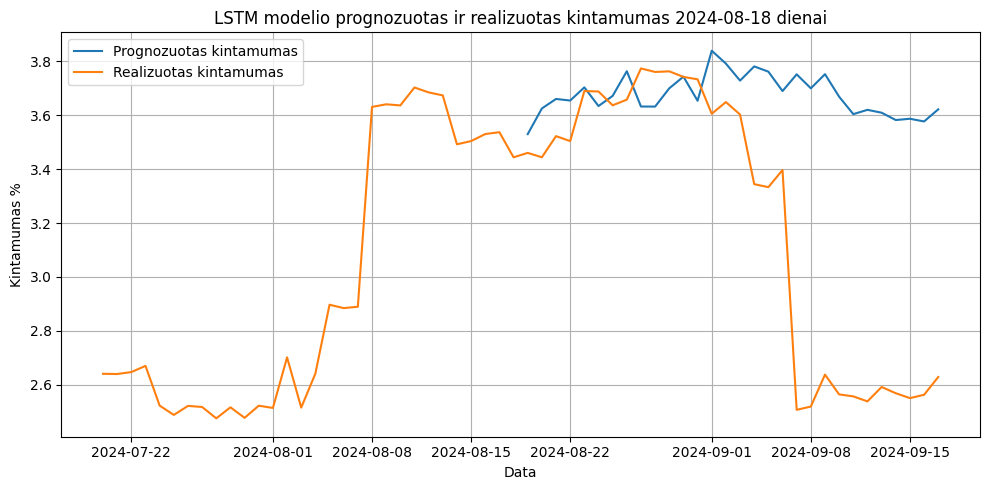

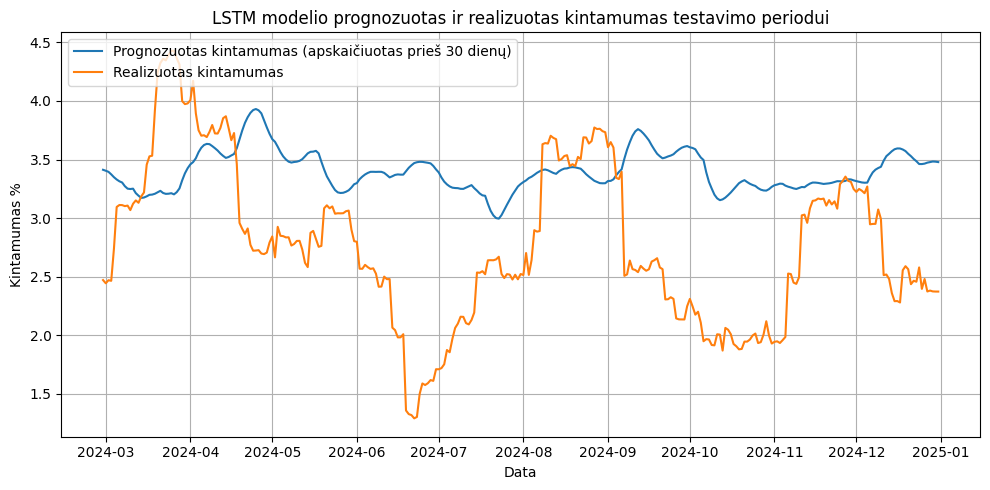

Metrics Scores: {'RMSE': 0.9368811271375251, 'MAPE': 34.42184283729975}


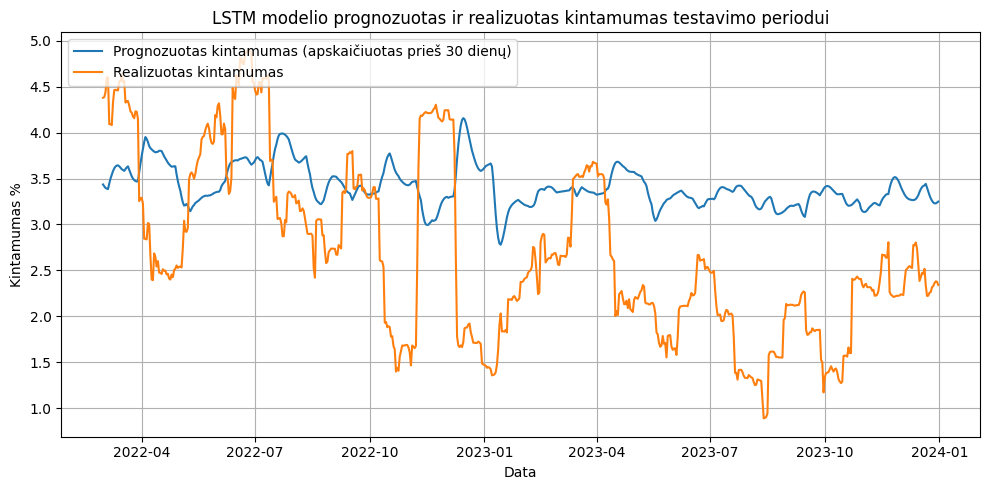

Metrics Scores: {'RMSE': 1.1877653922584004, 'MAPE': 51.326768148910915}


In [12]:
# Init
from google.colab import drive
drive.mount('/content/drive')
lstm_model = LSTMModel(lag=30, forecast_horizon=30)
X_train, y_train = lstm_model.preprocess_data(model_dataset.data['Realized_Volatility'])
lstm_model.build_model()
# Train
# history = lstm_model.train(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)
lstm_model.load_best_model()
# Test one
LSTMprediction = lstm_model.predict_One(test_dataset, center_index, p=True, retAll=True)
# Eval
Eval_LSTM_predictions = lstm_model.predict_over_range(test_dataset, 30, p=True, metrics=True)

# Calculate for training
Train_LSTM_predictions = lstm_model.predict_over_range(train_dataset, 30, p=True, metrics=True)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history.get('val_loss', None)

data_to_plot = {
    "Treniravimo nuostoliai": (range(len(loss)), loss),
    'Validavimo nuostoliai': (range(len(val_loss)), val_loss)
}

plotter = DiagramPlotter(float)
plotter.plot_multiple_data(data=data_to_plot, title="LSTM modelio treniravimo ir validavimo nuostoliai", xlabel="Data", ylabel="Nuostoliai")

#### Prints

In [ ]:
data_to_plot = {
    "pred": (LSTMprediction.index, LSTMprediction),
    'Actuals true': (test_dataset.data.index[center_index - 29:center_index + 30 + 1], test_dataset.data['Realized_Volatility'][center_index - 29:center_index + 30 + 1]),
    'GARCHprediction': (GARCHprediction.index, GARCHprediction),
    'index': (test_dataset.data.index[center_index - 29:center_index + 30 + 1], test_dataset.data['Index_Realized_Volatility'][center_index - 29:center_index + 30 + 1])
}

plotter = DiagramPlotter(figsize=(14, 8))
plotter.plot_multiple_data(data=data_to_plot, title="Kriptovaliutų rinkos indekso realizuotas kintamumas", xlabel="Data", ylabel="Kintamumas %")

In [ ]:
def print_range(Train_GARCH_predictions, Train_LSTM_predictions, dataset, dataset_name="tekstas", metrics=False):
  Train_GARCH_predictions.index = dataset.data.index[30:30 + len(Train_GARCH_predictions)] + pd.Timedelta(days=30)
  Train_LSTM_predictions.index = dataset.data.index[30:30 + len(Train_LSTM_predictions)] + pd.Timedelta(days=30)

  realized_volatility = dataset_btc.data.loc[
      dataset.data.index[30 + 30:30 + 30 + len(Train_LSTM_predictions)],
      'Realized_Volatility'
  ]

  data_to_plot = {
      f"GARCH prognozės (apskaičiuotos prieš 30 dienų)": (Train_GARCH_predictions.index, Train_GARCH_predictions['Predicted Volatility']),
      f"LSTM prognozės (apskaičiuotos prieš 30 dienų)": (Train_LSTM_predictions.index, Train_LSTM_predictions['Predicted Volatility']),
      f"Realizuotas kintamumas": (realized_volatility.index, realized_volatility),
      f"Kriptovaliutų rinkos indekso realizuotas kintamumas": (
          dataset.data.index[30 + 30:30 + 30 + len(Train_GARCH_predictions)],
          dataset.data['Index_Realized_Volatility'][30 + 30:30 + 30 + len(Train_GARCH_predictions)]
      )
  }
  plotter = DiagramPlotter()
  plotter.plot_multiple_data(data=data_to_plot, title=f"Perceptrono mokymo kintamumo duomenys ir faktinis realizuotas kintamumas", xlabel="Data", ylabel="Kintamumas %")

  y_true = realized_volatility
  y_pred = dataset.data['Index_Realized_Volatility'][30 + 30:30 + 30 + len(Train_GARCH_predictions)]

  tester = MetricsTester()
  scores = tester.evaluate_metrics(y_true, y_pred)
  print("indekso Metrics Scores:", scores)

print_range(Train_GARCH_predictions, Train_LSTM_predictions, train_dataset, dataset_name="Mokymo aibė")
print_range(Eval_GARCH_predictions, Eval_LSTM_predictions, test_dataset, dataset_name="Testavimo aibė", metrics=True)


### Big Model

In [ ]:
import numpy as np

class SigmoidNeuron:
    def __init__(self):
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.eval_loss_history = []
        self.eval_accuracy_history = []
        self.weights = None
        self.bias = None

    def fit(self, X, y, X_eval, y_eval, epochs=10, learning_rate=0.01):
        num_samples = X.shape[0]
        num_features = X.shape[1]
        self.weights = [-0.1926302, -0.28312313, 0.05449149]#np.random.uniform(-1, 1, size=num_features)
        self.bias = 0 #np.random.uniform(-1, 1)
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.eval_loss_history = []
        self.eval_accuracy_history = []
        print(self.weights)

        for epoch in range(epochs):
            predicted_train = self.predict(X, activation="linear")

            train_loss = np.mean((y - predicted_train) ** 2)
            self.train_loss_history.append(train_loss)

            train_accuracy = 1 - np.mean(np.abs(y - predicted_train))
            self.train_accuracy_history.append(train_accuracy)

            predicted_eval = self.predict(X_eval, activation="linear")

            eval_loss = np.mean((y_eval - predicted_eval) ** 2)
            self.eval_loss_history.append(eval_loss)

            eval_accuracy = 1 - np.mean(np.abs(y_eval - predicted_eval))
            self.eval_accuracy_history.append(eval_accuracy)

            dw = (-2 / num_samples) * np.dot(X.T, (y - predicted_train))
            db = (-2 / num_samples) * np.sum(y - predicted_train)

            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

            # print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")



    def predict(self, X, activation="linear"):
        linear_output = np.dot(X, self.weights) + self.bias
        if activation == "sigmoid":
            return self.sigmoid(linear_output)
        elif activation == "linear":
            return linear_output
        else:
            raise ValueError("Unsupported activation type")

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def prepare_perceptron_data(self, Train_GARCH_predictions, Train_LSTM_predictions, dataset):
        Train_GARCH_predictions.index = dataset.data.index[30:30 + len(Train_GARCH_predictions)] + pd.Timedelta(days=30)
        Train_LSTM_predictions.index = dataset.data.index[30:30 + len(Train_LSTM_predictions)] + pd.Timedelta(days=30)

        realized_volatility = dataset.data.loc[
            dataset.data.index[30 + 30:30 + 30 + len(Train_LSTM_predictions)],
            'Realized_Volatility'
        ]

        X = np.column_stack((
            Train_GARCH_predictions['Predicted Volatility'].values,
            Train_LSTM_predictions['Predicted Volatility'].values,
            dataset.data['Index_Realized_Volatility'][30:30  + len(Train_GARCH_predictions)].values
        ))
        y = realized_volatility.values

        return X, y

    def plot_accuracy_and_loss(self):
      data_to_plot = {
          "Treniravimo nuostoliai": (range(len(self.train_loss_history)), self.train_loss_history),
          "Validavimo nuostoliai": (range(len(self.eval_loss_history)), self.eval_loss_history)
      }
      plotter = DiagramPlotter()
      plotter.plot_multiple_data(
          data=data_to_plot,
          title="Modelio treniravimo ir validavimo nuostoliai",
          xlabel="Epocha",
          ylabel="Nuostoliai"
      )

      data_to_plot = {
          "Treniravimo tikslumas": (range(len(self.train_accuracy_history)), self.train_accuracy_history),
          "Validavimo tikslumas": (range(len(self.eval_accuracy_history)), self.eval_accuracy_history)
      }
      plotter = DiagramPlotter()
      plotter.plot_multiple_data(
          data=data_to_plot,
          title="Modelio treniravimo ir validavimo tikslumas",
          xlabel="Epocha",
          ylabel="Tikslumas"
      )



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

sigmoidNeuron = SigmoidNeuron()

X, y = sigmoidNeuron.prepare_perceptron_data(Train_GARCH_predictions, Train_LSTM_predictions, train_dataset)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_eval, y_train, y_eval = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

sigmoidNeuron.fit(X_train, y_train, X_eval, y_eval, epochs=500, learning_rate=0.05)

sigmoidNeuron.plot_accuracy_and_loss()

y_pred_normalized = sigmoidNeuron.predict(X_eval, activation="linear")
y_pred = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, 1)).flatten()
y_eval_original = scaler_y.inverse_transform(y_eval.reshape(-1, 1)).flatten()

sigmoidNeuron.bias

Neuron weights are:  [ 0.22255949 -0.15501419  0.26008018]
Neuron bias is:  0.3204293504759971
[0.3648888  0.36136533 0.35960056 0.34804708 0.3467289 ]
[2.34968157 2.33557361 2.32850747 2.28224738 2.2769694 ]


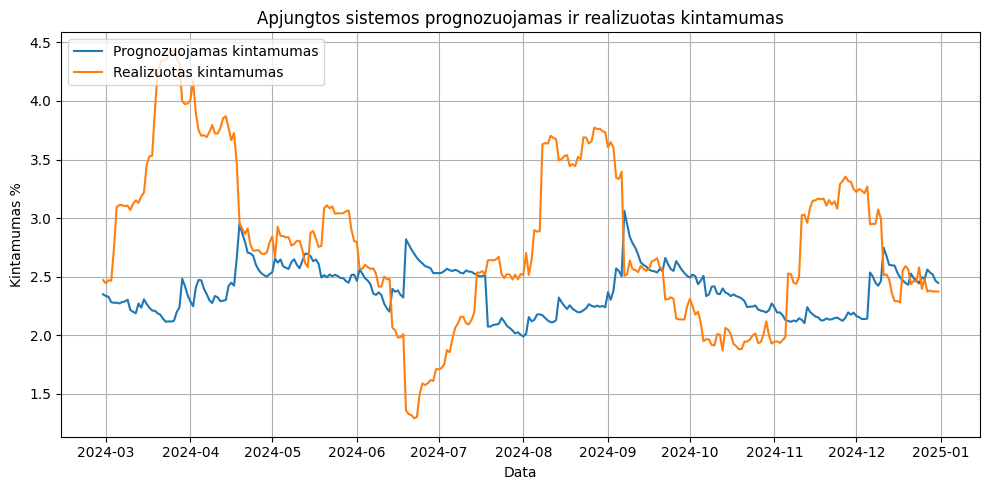

Metrics Scores: {'RMSE': 0.8593725226643409, 'MAPE': 23.060023672193854}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, X_test, y_test, scaler_X, scaler_y, test_dataset):
    X_test_normalized = scaler_X.transform(X_test)
    y_test_normalized = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    y_pred_normalized = model.predict(X_test_normalized, activation="linear")
    y_pred = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, 1)).flatten()

    realized_volatility = dataset_btc.data.loc[
      test_dataset.data.index[30 + 30:30 + 30 + len(Train_LSTM_predictions)],
      'Realized_Volatility'
    ]

    data_to_plot = {
        f"Prognozuojamas kintamumas": (realized_volatility.index, y_pred),
        f"Realizuotas kintamumas": (realized_volatility.index, test_dataset.data['Realized_Volatility'][30 + 30:30 + 30 + len(Train_LSTM_predictions)])
    }
    plotter = DiagramPlotter()
    plotter.plot_multiple_data(data=data_to_plot, title=f"Apjungtos sistemos prognozuojamas ir realizuotas kintamumas", xlabel="Data", ylabel="Kintamumas %")

    y_true = test_dataset.data['Realized_Volatility'][30 + 30:30 + 30 + len(Train_LSTM_predictions)]
    y_pred = y_pred
    tester = MetricsTester()
    scores = tester.evaluate_metrics(y_true, y_pred)
    print("Metrics Scores:", scores)

print("Neuron weights are: ", sigmoidNeuron.weights)
print("Neuron bias is: ", sigmoidNeuron.bias)

X_test, y_test = sigmoidNeuron.prepare_perceptron_data(Eval_GARCH_predictions, Eval_LSTM_predictions, test_dataset)

test_model(sigmoidNeuron, X_test, y_test, scaler_X, scaler_y, test_dataset)

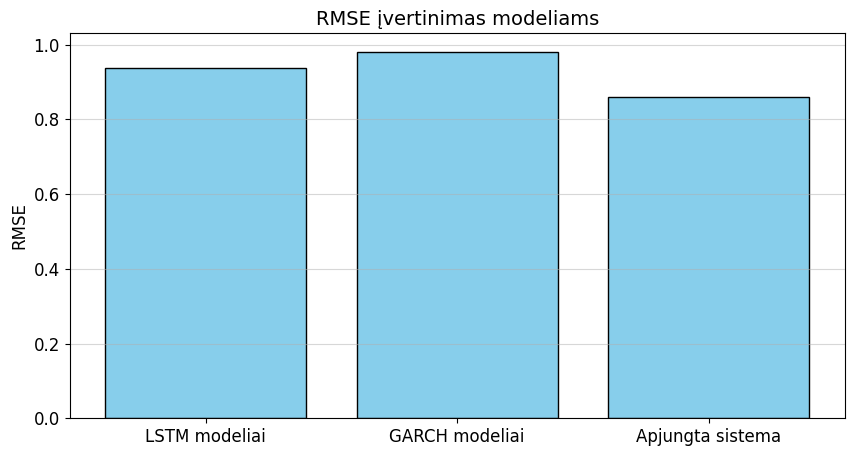

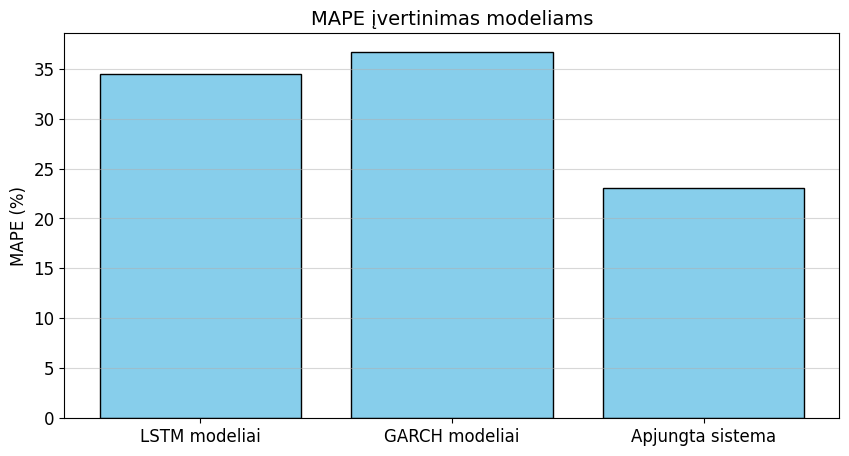

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['LSTM modeliai', 'GARCH modeliai', 'Apjungta sistema']
rmse_scores = [0.9368811271375251, 0.981542234110623, 0.8593725226643409]
mape_scores = [34.42184283729975, 36.70723269301766, 23.060023672193854]

plt.figure(figsize=(10, 5))
plt.bar(models, rmse_scores, color='skyblue', edgecolor='black')
plt.title('RMSE įvertinimas modeliams', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(models, mape_scores, color='skyblue', edgecolor='black')
plt.title('MAPE įvertinimas modeliams', fontsize=14)
plt.ylabel('MAPE (%)', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()